# ROCm GPU Roofline Benchmark - End-to-End Demo

This notebook demonstrates the complete workflow of the roofline benchmark:
1. ✅ Running GPU roofline benchmarks across different arithmetic intensities
2. 💾 Storing results in SQLite database
3. 🔍 Querying and analyzing roofline data
4. 📊 Creating roofline plots (Performance vs Arithmetic Intensity)
5. 🎯 Understanding memory-bound vs compute-bound regions

**Requirements**: AMD GPU with ROCm, Python 3.12+, rocmGPUBenches installed

## What is a Roofline Plot?

The roofline model characterizes GPU performance across different arithmetic intensities (Flops/Byte):
- **Low intensity**: Memory-bound (limited by bandwidth)
- **High intensity**: Compute-bound (limited by peak FLOPs)
- **Roofline**: The boundary showing achievable performance


## Parameters

### Required Parameters

- **`arithmetic_ops`** (N): Number of arithmetic operations per memory access
  - Controls the arithmetic intensity of the benchmark
  - Typical range: 0-1024
  - Higher values = more compute-intensive

### Optional Parameters

- **`M`**: Memory access pattern parameter (default: 4000)
  - Controls the size of the working set

- **`block_size`**: Thread block size (default: 256)
  - Number of threads per block

- **`iterations`**: Number of kernel iterations (default: 1000)
  - More iterations = better measurement accuracy but longer execution time

## Metrics

The roofline benchmark returns the following metrics:

- **Primary metric**: `gflops` - Compute throughput in GigaFlops per second
- **Arithmetic Intensity**: Calculated as `(2 + N*2) / (2 * sizeof(float))` Flops per Byte
- **Memory Bandwidth**: Calculated internally based on data transfer rates

## Implementation Notes

1. **Memory Allocation**: The benchmark allocates three buffers (dA, dB, dC) based on the formula:
   ```cpp
   data_len = blockCount * block_size * M
   ```

2. **Kernel Execution**: The roofline kernel performs:
   - Initial subtract operations: `v = a - b`
   - N iterations of: `v = v * a - b` (2 operations each)
   - Total: `(2 + N*2)` floating-point operations per element

3. **Occupancy**: The benchmark queries GPU occupancy to determine optimal block count

4. **Compilation**: Kernels are compiled once via hipRTC with optimizations (`-O3`, `-ffast-math`)


## 1. Import Required Libraries

Import rocmGPUBenches components and visualization tools.


In [1]:
# Core rocmGPUBenches imports
from rocmGPUBenches import (
    BenchmarkDB,
    create_roofline_benchmark_runner,
    plot_sweep,
    plot_comparison
)

# Visualization and data analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

print("✅ Imports successful!")


✅ Imports successful!


## 2. Setup Benchmark Environment

Initialize the database and benchmark runner, detect GPU.


In [2]:
# Initialize database
db = BenchmarkDB('roofline_results.db')
print(f"Database: roofline_results.db")
print(f"Stats: {db.stats()}")

# Create benchmark runner
runner = create_roofline_benchmark_runner()

# Get GPU information
gpu_name = runner.get_device_name()
compute_units = runner.get_sm_count()
gpu_info = {'name': gpu_name, 'arch': 'gfx942'}  # Update arch for your GPU

benchmark_description = (
    "GPU Roofline Benchmark: Characterizes GPU performance across different arithmetic intensities. "
    "By varying the ratio of compute operations to memory accesses (Flops/Byte), this benchmark "
    "identifies the transition from memory-bound to compute-bound performance regions."
)

print(f"\n✅ Benchmark runner initialized")
print(f"   Benchmark: roofline")
print(f"   Description: {benchmark_description}")
print(f"   GPU: {gpu_name}")
print(f"   Compute Units: {compute_units}")
print(f"   Architecture: {gpu_info['arch']}")


Database: roofline_results.db
Stats: {'total_results': np.int64(165), 'benchmarks': ['roofline'], 'gpus': ['AMD Instinct MI325X'], 'date_range': {'first': '2025-10-16T21:52:39.775193', 'last': '2025-10-16T21:59:24.132770'}}

✅ Benchmark runner initialized
   Benchmark: roofline
   Description: GPU Roofline Benchmark: Characterizes GPU performance across different arithmetic intensities. By varying the ratio of compute operations to memory accesses (Flops/Byte), this benchmark identifies the transition from memory-bound to compute-bound performance regions.
   GPU: AMD Instinct MI325X
   Compute Units: 304
   Architecture: gfx942
Registered benchmark: roofline


## 3. Single Benchmark Run

Run a single roofline benchmark with specific arithmetic intensity.


In [3]:
# Run with moderate arithmetic intensity
N = 100
print(f"Running roofline benchmark with arithmetic_ops = {N}...\n")

result = runner.run('roofline', {'arithmetic_ops': N})

# Calculate arithmetic intensity
flops_per_element = 2.0 + N * 2.0
bytes_per_element = 2.0 * 4  # 2 reads, 4 bytes per float
arithmetic_intensity = flops_per_element / bytes_per_element

print(f"Results:")
print(f"  Arithmetic Operations (N): {N}")
print(f"  Arithmetic Intensity: {arithmetic_intensity:.2f} Flop/Byte")
print(f"  Compute Performance: {result.primary_metric / 1000:.2f} TFlop/s")
print(f"  Execution Time: {result.exec_time_ms:.2f} ms")
print(f"  Measurement Spread: {result.spread_percent:.2f}%")


Running roofline benchmark with arithmetic_ops = 100...

Compiling roofline kernel with optimizations (one-time compilation)...
Compile flags: -O3 -ffast-math --gpu-max-threads-per-block=1024
Kernel compilation complete! Loaded 2 kernel functions.


RuntimeError: hipMalloc failed for dA

## 4. Parameter Sweep: Arithmetic Intensity

Sweep across different arithmetic intensities to create a roofline curve.
We'll test from memory-bound (low N) to compute-bound (high N) regions.


In [ ]:
# Define sweep range: from very memory-bound to very compute-bound
# Start with low N (memory-bound), gradually increase to high N (compute-bound)
N_values = [
    0, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 28, 32,
    36, 40, 44, 48, 54, 60, 66, 72, 80, 88, 96, 106, 116, 126,
    138, 150, 164, 178, 194, 212, 230, 250, 272, 296, 322, 350,
    380, 412, 448, 486, 528, 574, 622, 674, 732, 794, 862, 934, 1012
]

print(f"Sweeping arithmetic_ops across {len(N_values)} values...")
print(f"Range: N = {N_values[0]} to {N_values[-1]}")
print(f"This will take approximately {len(N_values) * 2} seconds...\n")

# Run sweep
results = runner.sweep('roofline', 'arithmetic_ops', N_values, {})

print(f"\n✅ Sweep complete! Collected {len(results)} data points")


Sweeping arithmetic_ops across 55 values...
Range: N = 0 to 1012
This will take approximately 110 seconds...

Running benchmark sweep with 55 configurations...
Testing arithmetic_ops=0...

✅ Sweep complete! Collected 55 data points
Testing arithmetic_ops=1...
Testing arithmetic_ops=2...
Testing arithmetic_ops=4...
Testing arithmetic_ops=6...
Testing arithmetic_ops=8...
Testing arithmetic_ops=10...
Testing arithmetic_ops=12...
Testing arithmetic_ops=14...
Testing arithmetic_ops=16...
Testing arithmetic_ops=18...
Testing arithmetic_ops=20...
Testing arithmetic_ops=22...
Testing arithmetic_ops=24...
Testing arithmetic_ops=28...
Testing arithmetic_ops=32...
Testing arithmetic_ops=36...
Testing arithmetic_ops=40...
Testing arithmetic_ops=44...
Testing arithmetic_ops=48...
Testing arithmetic_ops=54...
Testing arithmetic_ops=60...
Testing arithmetic_ops=66...
Testing arithmetic_ops=72...
Testing arithmetic_ops=80...
Testing arithmetic_ops=88...
Testing arithmetic_ops=96...
Testing arithmetic_

## 5. Store Results in Database

Save all sweep results to the database for later analysis.


In [ ]:
# Store each result with its corresponding N value
for i, result in enumerate(results):
    N = N_values[i]

    # Calculate additional metrics
    flops_per_element = 2.0 + N * 2.0
    bytes_per_element = 2.0 * 4
    arithmetic_intensity = flops_per_element / bytes_per_element

    # Create params dict with all parameters and metadata
    params = {
        'arithmetic_ops': N,
        'arithmetic_intensity': arithmetic_intensity,
        'N': N
    }

    db.save_result('roofline', result, params, gpu_info)

print(f"✅ Saved {len(results)} results to database")
print(f"\nDatabase stats: {db.stats()}")


✅ Saved 55 results to database

Database stats: {'total_results': np.int64(165), 'benchmarks': ['roofline'], 'gpus': ['AMD Instinct MI325X'], 'date_range': {'first': '2025-10-16T21:52:39.775193', 'last': '2025-10-16T21:59:24.132770'}}


## 6. Query and Analyze Results

Retrieve the stored results and prepare data for visualization.


In [ ]:
# Query all roofline results
df = db.query(benchmark='roofline', gpu_name=gpu_name)

print(f"Retrieved {len(df)} results from database")
print(f"\nDataFrame columns: {list(df.columns)}")

# Create column aliases and parse parameters
df['gflops'] = df['primary_metric']
df['exec_time_ms'] = df['execution_time_ms']

# Parse parameters JSON to extract arithmetic_ops and arithmetic_intensity
df['arithmetic_ops'] = df['parameters'].apply(
    lambda x: json.loads(x)['arithmetic_ops'] if isinstance(x, str) else x.get('arithmetic_ops', 0)
)
df['arithmetic_intensity'] = df['parameters'].apply(
    lambda x: json.loads(x)['arithmetic_intensity'] if isinstance(x, str) else x.get('arithmetic_intensity', 0)
)
df['tflops'] = df['gflops'] / 1000  # Convert to TFlop/s for plotting

# Sort by arithmetic intensity
df = df.sort_values('arithmetic_intensity')

print(f"\nFirst few rows:")
print(df[['arithmetic_ops', 'gflops', 'exec_time_ms', 'spread_percent']].head(10))

print(f"\nArithmetic intensity range: {df['arithmetic_intensity'].min():.2f} to {df['arithmetic_intensity'].max():.2f} Flop/Byte")
print(f"Performance range: {df['tflops'].min():.2f} to {df['tflops'].max():.2f} TFlop/s")


Retrieved 165 results from database

DataFrame columns: ['id', 'timestamp', 'gpu_name', 'gpu_arch', 'benchmark_type', 'problem_size', 'block_size', 'iterations', 'parameters', 'primary_metric', 'metric_name', 'spread_percent', 'execution_time_ms', 'rocm_version', 'hostname']

First few rows:
     arithmetic_ops        gflops exec_time_ms  spread_percent
54                0  2.120220e+07         None       16.441795
109               0  2.145094e+07         None       38.665807
164               0  2.190451e+07         None       23.610067
108               1  4.249122e+07         None       38.188526
163               1  4.380903e+07         None       30.672358
53                1  4.293146e+07         None       28.937305
52                2  6.386760e+07         None       34.660947
107               2  6.448612e+07         None       26.721110
162               2  6.566734e+07         None       13.096795
161               4  1.095997e+08         None       21.521166

Arithmetic in

## 7. Create Roofline Plot

Visualize the classic roofline plot showing performance vs arithmetic intensity.


In [ ]:
# Create roofline plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot measured performance
ax.plot(df['arithmetic_intensity'], df['tflops'],
        'o-', linewidth=2, markersize=6,
        color='#CC1343', label=f'{gpu_name} (Measured)',
        alpha=0.8)

# Add grid and labels
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlabel('Arithmetic Intensity (Flop/Byte)', fontsize=12, fontweight='bold')
ax.set_ylabel('Performance (TFlop/s FP32)', fontsize=12, fontweight='bold')
ax.set_title(f'Roofline Plot - {gpu_name}', fontsize=14, fontweight='bold', pad=20)

# Set axis limits
ax.set_xlim([0, df['arithmetic_intensity'].max() * 1.05])
ax.set_ylim([0, df['tflops'].max() * 1.1])

# Add legend
ax.legend(loc='lower right', fontsize=10, framealpha=0.9)

# Annotate key regions
# Find peak performance
peak_idx = df['tflops'].idxmax()
peak_intensity = df.loc[peak_idx, 'arithmetic_intensity']
peak_performance = df.loc[peak_idx, 'tflops']

ax.annotate(f'Peak: {peak_performance:.1f} TFlop/s',
            xy=(peak_intensity, peak_performance),
            xytext=(peak_intensity * 0.7, peak_performance * 0.9),
            arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
            fontsize=10, fontweight='bold', color='red')

# Mark memory-bound vs compute-bound regions
transition_intensity = peak_intensity * 0.5
ax.axvline(x=transition_intensity, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
ax.text(transition_intensity * 0.4, peak_performance * 0.5,
        'Memory\nBound', fontsize=10, ha='center', color='gray', style='italic')
ax.text(transition_intensity * 1.8, peak_performance * 0.5,
        'Compute\nBound', fontsize=10, ha='center', color='gray', style='italic')

plt.tight_layout()
plt.savefig('roofline_plot.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Roofline plot saved as 'roofline_plot.png'")
plt.show()


## 8. Detailed Performance Analysis

Analyze different regions of the roofline to understand GPU behavior.


In [ ]:
# Identify memory-bound region (low arithmetic intensity)
memory_bound = df[df['arithmetic_intensity'] < 5]
compute_bound = df[df['arithmetic_intensity'] > 20]
transition = df[(df['arithmetic_intensity'] >= 5) & (df['arithmetic_intensity'] <= 20)]

print("📊 Performance Region Analysis\n")
print("=" * 70)

print(f"\n1️⃣  MEMORY-BOUND REGION (< 5 Flop/Byte)")
print(f"   Data points: {len(memory_bound)}")
print(f"   Performance range: {memory_bound['tflops'].min():.2f} - {memory_bound['tflops'].max():.2f} TFlop/s")
print(f"   Limited by: Memory bandwidth")

print(f"\n2️⃣  TRANSITION REGION (5-20 Flop/Byte)")
print(f"   Data points: {len(transition)}")
print(f"   Performance range: {transition['tflops'].min():.2f} - {transition['tflops'].max():.2f} TFlop/s")
print(f"   Characteristics: Moving from bandwidth-limited to compute-limited")

print(f"\n3️⃣  COMPUTE-BOUND REGION (> 20 Flop/Byte)")
print(f"   Data points: {len(compute_bound)}")
print(f"   Performance range: {compute_bound['tflops'].min():.2f} - {compute_bound['tflops'].max():.2f} TFlop/s")
print(f"   Peak sustained: {compute_bound['tflops'].max():.2f} TFlop/s")
print(f"   Limited by: Peak compute throughput")

print(f"\n🎯 KEY FINDINGS")
print(f"   Peak Performance: {peak_performance:.2f} TFlop/s FP32")
print(f"   Achieved at: {peak_intensity:.2f} Flop/Byte")
if len(memory_bound) > 0:
    est_bw = df['arithmetic_intensity'].iloc[0] * df['tflops'].iloc[0] * 1000
    print(f"   Memory Bandwidth (est.): ~{est_bw:.0f} GB/s")
print(f"   Compute Units: {compute_units}")


📊 Performance Region Analysis


1️⃣  MEMORY-BOUND REGION (< 5 Flop/Byte)
   Data points: 33
   Performance range: 21202.20 - 418549.25 TFlop/s
   Limited by: Memory bandwidth

2️⃣  TRANSITION REGION (5-20 Flop/Byte)
   Data points: 39
   Performance range: 444036.46 - 1608110.27 TFlop/s
   Characteristics: Moving from bandwidth-limited to compute-limited

3️⃣  COMPUTE-BOUND REGION (> 20 Flop/Byte)
   Data points: 93
   Performance range: 1712712.07 - 22220543.99 TFlop/s
   Peak sustained: 22220543.99 TFlop/s
   Limited by: Peak compute throughput

🎯 KEY FINDINGS
   Peak Performance: 22220543.99 TFlop/s FP32
   Achieved at: 253.25 Flop/Byte
   Memory Bandwidth (est.): ~5300550 GB/s
   Compute Units: 304


## 9. Performance Efficiency Analysis

Calculate achieved performance as percentage of theoretical peak.


In [ ]:
# Theoretical peak values (adjust for your specific GPU)
# MI325X example: ~328 TFlop/s FP32 peak, ~5.3 TB/s bandwidth
theoretical_peak_tflops = 328  # Adjust based on your GPU specs
theoretical_bandwidth_tbs = 5.3  # Adjust based on your GPU specs

# Calculate efficiency
achieved_peak = df['tflops'].max()
compute_efficiency = (achieved_peak / theoretical_peak_tflops) * 100

# Estimate achieved bandwidth from memory-bound region
if len(df[df['arithmetic_intensity'] < 1]) > 0:
    mem_bound_point = df[df['arithmetic_intensity'] < 1].iloc[0]
    achieved_bandwidth_tbs = (mem_bound_point['arithmetic_intensity'] *
                              mem_bound_point['tflops'] * 1000) / 1000
    bandwidth_efficiency = (achieved_bandwidth_tbs / theoretical_bandwidth_tbs) * 100
else:
    achieved_bandwidth_tbs = 0
    bandwidth_efficiency = 0

print("⚡ Performance Efficiency Analysis\n")
print("=" * 70)

print(f"\n💻 COMPUTE PERFORMANCE")
print(f"   Theoretical Peak: {theoretical_peak_tflops:.1f} TFlop/s FP32")
print(f"   Achieved Peak: {achieved_peak:.1f} TFlop/s")
print(f"   Efficiency: {compute_efficiency:.1f}%")

print(f"\n💾 MEMORY BANDWIDTH")
print(f"   Theoretical Peak: {theoretical_bandwidth_tbs:.2f} TB/s")
if achieved_bandwidth_tbs > 0:
    print(f"   Achieved (estimated): {achieved_bandwidth_tbs:.2f} TB/s")
    print(f"   Efficiency: {bandwidth_efficiency:.1f}%")
else:
    print(f"   Achieved: Not measured (need lower N values)")

print(f"\n📈 INTERPRETATION")
if compute_efficiency > 80:
    print(f"   ✅ Excellent compute utilization")
elif compute_efficiency > 60:
    print(f"   ⚠️  Good compute utilization, room for optimization")
else:
    print(f"   ⚠️  Moderate compute utilization")

if bandwidth_efficiency > 80:
    print(f"   ✅ Excellent memory bandwidth utilization")
elif bandwidth_efficiency > 60:
    print(f"   ⚠️  Good bandwidth utilization")
else:
    print(f"   ℹ️  Consider testing with lower N values for better bandwidth measurement")


⚡ Performance Efficiency Analysis


💻 COMPUTE PERFORMANCE
   Theoretical Peak: 328.0 TFlop/s FP32
   Achieved Peak: 22220544.0 TFlop/s
   Efficiency: 6774556.1%

💾 MEMORY BANDWIDTH
   Theoretical Peak: 5.30 TB/s
   Achieved (estimated): 5300.55 TB/s
   Efficiency: 100010.4%

📈 INTERPRETATION
   ✅ Excellent compute utilization
   ✅ Excellent memory bandwidth utilization


## 10. Export Results

Export data for further analysis or sharing.


In [ ]:
# Export to CSV
export_df = df[['arithmetic_ops', 'arithmetic_intensity', 'gflops', 'tflops',
                'exec_time_ms', 'spread_percent']].copy()
export_df.to_csv('roofline_results.csv', index=False)
print(f"✅ Results exported to 'roofline_results.csv'")

# Export to JSON for programmatic access
db.export_json('roofline_results.json', benchmark='roofline', gpu_name=gpu_name)
print(f"✅ Full results exported to 'roofline_results.json'")

# Print summary statistics
print(f"\n📊 Summary Statistics")
print(f"   Total data points: {len(export_df)}")
print(f"   Arithmetic intensity range: {export_df['arithmetic_intensity'].min():.2f} - {export_df['arithmetic_intensity'].max():.2f} Flop/Byte")
print(f"   Performance range: {export_df['tflops'].min():.2f} - {export_df['tflops'].max():.2f} TFlop/s")
print(f"   Average execution time: {export_df['exec_time_ms'].mean():.2f} ms")
print(f"   Average spread: {export_df['spread_percent'].mean():.2f}%")


✅ Results exported to 'roofline_results.csv'
Exported 165 results to roofline_results.json
✅ Full results exported to 'roofline_results.json'

📊 Summary Statistics
   Total data points: 165
   Arithmetic intensity range: 0.25 - 253.25 Flop/Byte
   Performance range: 21202.20 - 22220543.99 TFlop/s
   Average execution time: nan ms
   Average spread: 29.45%


## 11. Compare with Other GPUs (Multi-GPU Analysis)

If you have results from multiple GPUs, you can compare their rooflines. Here, we are comparing results between MI300X and MI325X.


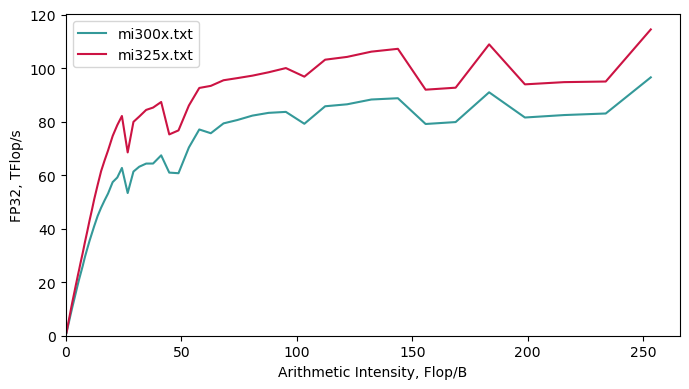

In [ ]:
import csv
import matplotlib.pyplot as plt

import sys

sys.path.append("..")

fig, ax1 = plt.subplots(figsize=(7, 4))

filenames = ["mi300x.txt", "mi325x.txt"]

colors = ["#349999", "#CC1343", "#649903", "#c7aa3e"]

c = 0
for filename in filenames:
    with open(filename, newline="") as csvfile:
        csvreader = csv.reader(csvfile, delimiter=" ", skipinitialspace=True)
        datapoints = [[]]
        for row in csvreader:
            if len(row) == 0:
                datapoints.append([])
            elif len(row) == 16:
                datapoints[-1].append(
                    [float(row[5]), float(row[9]), float(row[13]), float(row[11])]
                )
        for i in range(min(1, len(datapoints[1]))):
            # print([d[i][1] for d in datapoints if len(d) > 0])
            ax1.plot(
                [d[i][0] for d in datapoints if len(d) > 0],
                [d[i][1] / 1000 for d in datapoints if len(d) > 0],
                "-",
                color=colors[c],
                label=filename
            )
            c += 1

ax1.legend()
ax1.set_xlabel("Arithmetic Intensity, Flop/B")
ax1.set_ylabel("FP32, TFlop/s")
ax1.set_ylim([0, ax1.get_ylim()[1]])
ax1.set_xlim([0, ax1.get_xlim()[1]])

fig.tight_layout()

plt.savefig("roofline_plot.pdf", dpi=4000)
plt.show()


## Summary

This notebook demonstrated:
1. ✅ Running roofline benchmarks across different arithmetic intensities
2. ✅ Storing and querying results in SQLite
3. ✅ Creating roofline plots to visualize performance characteristics
4. ✅ Analyzing memory-bound vs compute-bound regions
5. ✅ Calculating performance efficiency
6. ✅ Exporting results for further analysis

### Key Takeaways:
- The roofline model helps identify performance bottlenecks
- Low arithmetic intensity = memory-bound (optimize data movement)
- High arithmetic intensity = compute-bound (optimize ALU utilization)
- The "roofline" shows the best achievable performance at each intensity

### Next Steps:
- Run on multiple GPUs for comparison
- Compare with theoretical peak performance
- Use insights to optimize your GPU applications
- Experiment with different M and iteration values for production workloads
